In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns

In [17]:
cols = ['id','drugName','condition','review','rating','date','usefulCount']
train = pd.read_csv('drugsComTrain_raw.tsv', sep='\t', names=cols ,header=0)
test = pd.read_csv('drugsComTest_raw.tsv', sep='\t', names=cols, header=0)

In [10]:
display(train.head())
display(test.head())

,id,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


,id,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


In [11]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
id             161297 non-null int64
drugName       161297 non-null object
condition      160398 non-null object
review         161297 non-null object
rating         161297 non-null float64
date           161297 non-null object
usefulCount    161297 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
id             53766 non-null int64
drugName       53766 non-null object
condition      53471 non-null object
review         53766 non-null object
rating         53766 non-null float64
date           53766 non-null object
usefulCount    53766 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 2.9+ MB
None


C:\Users\HP\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


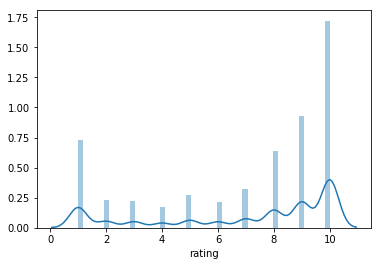

In [15]:
sns.distplot(train['rating'])

In [18]:
#replace &#039 --> '
def replace_apos(text):
    text = text.replace("&#039;","'")
    return text
train['review'] = train['review'].apply(replace_apos)
test['review'] = train['review'].apply(replace_apos)

In [4]:
#proses cleaning data
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
tokenizer = WordPunctTokenizer()
stop_words = set(stopwords.words('english'))
negation_dic = {"isn't":"is not", "aren't": "are not", "wasn't":"was not",
               "weren't":"were not", "haven't":"have not","hasn't":"has not",
               "hadn't":"had not","won't":"will not","wouldn't":"would not",
               "don't":"do not","doesn't":"does not","didn't":"did not",
               "can't":"can not","couldn't": "could not","shouldn't":"should not",
               "mightn't":"might not","mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negation_dic.keys())+r')\b')

def cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    #letters_only = re.sub("[^a-zA-Z]", " ", souped)
    lower_case = souped.lower()
    neg_handled = neg_pattern.sub(lambda x: negation_dic[x.group()],lower_case)
    letters_only = re.sub("[^a-zA-Z]"," ", neg_handled)
    #words = tokenizer.tokenize(lower_case)
    words = [x for x in tokenizer.tokenize(letters_only) if len(x)>1]
    filtered_words = [w for w in words if not w in stop_words]
    return (" ".join(filtered_words)).strip()
    

cleaned_data = []

for i in range(len(train)):
    cleaned_data.append(cleaner(train['review'][i]))

cleaned_test = []
for i in range(len(test)):
    cleaned_test.append(cleaner(test['review'][i]))
print('Done')

Done


In [5]:
#proses lemmatizing
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet

def tagging(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


def lemmatize_data(sentence):
    nltk_tag = nltk.pos_tag(nltk.word_tokenize(sentence))
    tagged = map(lambda x: (x[0], tagging(x[1])), nltk_tag)
    
    words = []
    for word, tag in tagged:
        if tag is None:
            words.append(word)
        else:
            words.append(lemmatizer.lemmatize(word, tag))
    return (" ".join(words))
lemmatized_data = []
for i in range(len(cleaned_data)):
    lemmatized_data.append(lemmatize_data(cleaned_data[i]))

lemmatized_test = []
for i in range(len(cleaned_test)):
    lemmatized_test.append(lemmatize_data(cleaned_test[i]))

In [6]:
#menyimpan hasil ke dalam dataframe
clean_df = pd.DataFrame(lemmatized_data, columns=['review'])
clean_df['rating'] = train['rating']
clean_df.info()
clean_df.to_csv('clean_data4.csv')

clean_test = pd.DataFrame(cleaned_test, columns=['review'])
clean_test['rating'] = test['rating']
clean_test.to_csv('test_clean.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 2 columns):
review    161297 non-null object
rating    161297 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [2]:
cols = ['No','review','rating']
df = pd.read_csv('clean_data4.csv', names=cols, header=0)
df.drop('No', axis=1, inplace=True)
df.head()

test = pd.read_csv('test_clean.csv', names=cols, header=0)
test.drop('No', axis=1, inplace=True)

In [3]:
#drop row with missing values
df[df.isnull().any(axis=1)].head()
print(np.sum(df.isnull().any(axis=1)))
print(df.isnull().any(axis=0))
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()


test[test.isnull().any(axis=1)].head()
print(np.sum(test.isnull().any(axis=1)))
print(test.isnull().any(axis=0))
test.dropna(inplace=True,axis=0)
test.reset_index(drop=True, inplace=True)

7
review     True
rating    False
dtype: bool
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161290 entries, 0 to 161289
Data columns (total 2 columns):
review    161290 non-null object
rating    161290 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB
2
review     True
rating    False
dtype: bool


In [4]:
X = df.review[pd.notnull(df.review)]
y = df.rating[pd.notnull(df.rating)]

X_test = test.review[pd.notnull(test.review)]
y_test = test.rating[pd.notnull(test.rating)]

from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X,y, test_size=0.1, random_state=0)

In [5]:
#Stochastic Gradient Descent Classifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score

text_clf_svm = Pipeline([('vect', CountVectorizer(ngram_range=(1,3))),
                        ('tfidf', TfidfTransformer(norm=None, smooth_idf=True, sublinear_tf=False,
                        use_idf=True)),
                        ('clf-svm', SGDClassifier(loss='hinge',alpha=1e-3, n_iter=5,random_state=0))])

text_clf_svm = text_clf_svm.fit(X_train.astype(str), y_train)
prediction = text_clf_svm.predict(X_validation.astype(str))
accuracy = accuracy_score(y_validation, prediction)
print("Accuracy ",accuracy)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Accuracy  0.7122574245148491


In [6]:
#cross validation
from sklearn.model_selection import cross_val_score

score = cross_val_score(text_clf_svm, X_train, y_train, cv=5, scoring='accuracy')

print(np.mean(score))

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:

0.6450561041275134


In [9]:
#confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_validation, prediction)


array([[1801,   36,   47,   26,   39,   17,   19,   21,   23,  109],
       [ 142,  381,   30,   12,   13,   11,   12,   17,   18,   42],
       [ 104,   16,  390,   21,   29,   13,    7,   22,   13,   52],
       [  56,    9,   15,  320,   14,   12,   12,   22,   14,   25],
       [  78,   16,   31,   27,  490,   24,   32,   34,   24,   69],
       [  45,   12,   23,   24,   25,  374,   19,   34,   38,   83],
       [  42,   17,   23,   40,   31,   27,  546,   59,   69,  114],
       [  76,   28,   36,   35,   40,   22,   68, 1118,  147,  302],
       [  76,   31,   36,   23,   50,   29,   44,  121, 1640,  661],
       [ 110,   24,   31,   37,   49,   35,   56,  134,  190, 4428]],
      dtype=int64)

In [12]:
from sklearn.naive_bayes import MultinomialNB
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,3))),
                        ('tfidf', TfidfTransformer(norm=None, smooth_idf=True, sublinear_tf=False,
                        use_idf=True)),
                        ('nb', MultinomialNB())])

text_clf = text_clf.fit(X_train.astype(str), y_train)
prediction = text_clf.predict(X_validation.astype(str))
accuracy = accuracy_score(y_validation, prediction)
print("Accuracy : ",accuracy)

Accuracy :  0.697253394506789


In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,3))),
                        ('tfidf', TfidfTransformer(norm=None, smooth_idf=True, sublinear_tf=False,
                        use_idf=True)),
                        ('nb', MultinomialNB())])

In [6]:
#cross validation
from sklearn.model_selection import cross_val_score

score = cross_val_score(text_clf, X_train, y_train, cv=5, scoring='accuracy')

print(np.mean(score))

0.6324286524028262


In [13]:
#confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_validation, prediction)


array([[1702,   38,   23,   10,   35,   14,   20,   61,   81,  154],
       [ 122,  378,   15,    2,   21,    5,   14,   25,   30,   66],
       [ 103,   17,  374,    6,   23,    6,   14,   35,   45,   44],
       [  47,    7,    4,  303,   18,    6,    8,   30,   38,   38],
       [  77,   10,   10,    7,  473,    7,   18,   71,   77,   75],
       [  51,    5,   11,    6,   18,  354,   27,   51,   64,   90],
       [  41,    6,    8,    4,   15,   13,  527,   80,  113,  161],
       [  74,    7,   10,    8,   27,    9,   32, 1137,  242,  326],
       [  60,    6,   11,    5,   18,    8,   26,  179, 1790,  608],
       [  81,   12,   10,   11,   18,   14,   46,  206,  488, 4208]],
      dtype=int64)

In [7]:
#jika feature selection menggunakan chi2
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, chi2


text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,3))),
                        ('tfidf', TfidfTransformer(norm=None, smooth_idf=True, sublinear_tf=False,
                        use_idf=True)),
                        ('chi2', SelectKBest(chi2, k=3000000)),
                        ('sgd', SGDClassifier(loss='hinge',alpha=1e-3, n_iter=5,random_state=0))])

text_clf = text_clf.fit(X_train.astype(str), y_train)
prediction = text_clf.predict(X_validation.astype(str))
accuracy = accuracy_score(y_validation, prediction)
print("Accuracy ",accuracy)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Accuracy  0.7141794283588567


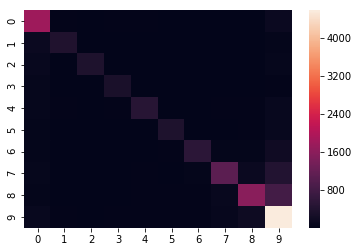

In [9]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_validation, prediction))

In [10]:
#jika feature selection menggunakan chi2

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, chi2


text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,3))),
                        ('tfidf', TfidfTransformer(norm=None, smooth_idf=True, sublinear_tf=False,
                        use_idf=True)),
                        ('chi2', SelectKBest(chi2, k=3000000)),
                        ('mnb', MultinomialNB())])

text_clf = text_clf.fit(X_train.astype(str), y_train)
prediction = text_clf.predict(X_validation.astype(str))
accuracy = accuracy_score(y_validation, prediction)
print("Accuracy ",accuracy)

Accuracy  0.6984313968627938


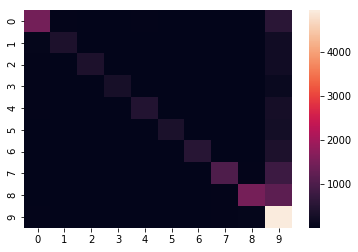

In [11]:
sns.heatmap(confusion_matrix(y_validation, prediction))